In [8]:
# Import the required packages
import pandas as pd
from sqlalchemy import create_engine
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [9]:
# Store the connection info

URI = "database-1.c5ekejexdq4k.us-east-1.rds.amazonaws.com"
PORT = "3306"
DB = "dublin_bike"
USER = "admin"
PASSWARD = "group888"

engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(USER, PASSWARD, URI, PORT, DB))

In [10]:
# read the table 

df_bike = pd.read_sql_table("bike_availibility", engine, parse_dates="True", index_col=0)
df_weather = pd.read_sql_table("weather", engine, parse_dates="True", index_col=0)

In [11]:
# Display some basic info of the data

display(df_bike.head())
print(df_bike.shape)

,ID,Number,Time,Available_bike_stands,Available_bikes,Status
0,3083,42,2022-02-16 00:10:58,3,27,OPEN
1,3084,30,2022-02-16 00:10:58,17,3,OPEN
2,3085,54,2022-02-16 00:10:58,16,17,OPEN
3,3086,108,2022-02-16 00:10:58,19,16,OPEN
4,3087,56,2022-02-16 00:10:58,26,14,OPEN


(495192, 6)


In [12]:
# Display some basic info of the data

display(df_weather.head())
print(df_weather.shape)

,ID,Time,Weather,Temp,Feels_like,Humidity
0,29,2022-02-16 00:10:58,Clear,15.07,13.44,31
1,30,2022-02-16 00:20:57,Clear,14.99,13.38,32
2,31,2022-02-16 00:31:55,Clear,14.80,13.17,32
3,32,2022-02-16 00:41:54,Clear,14.88,13.29,33
4,33,2022-02-16 00:51:26,Clear,14.64,13.02,33


(4499, 6)


In [13]:
# Merge the 2 tables

df_combine = df_bike.merge(df_weather,left_on='Time', right_on='Time')
df_combine
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495192 entries, 0 to 495191
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID_x                   495192 non-null  int64         
 1   Number                 495192 non-null  int64         
 2   Time                   495192 non-null  datetime64[ns]
 3   Available_bike_stands  495192 non-null  int64         
 4   Available_bikes        495192 non-null  int64         
 5   Status                 495192 non-null  object        
 6   ID_y                   495192 non-null  int64         
 7   Weather                495192 non-null  object        
 8   Temp                   495192 non-null  float64       
 9   Feels_like             495192 non-null  object        
 10  Humidity               495192 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 45.3+ MB


In [14]:
# Perform test on Specific group(station)
# Data preperation

df_test_station=df_combine.groupby("Number").get_group(42)
df_test_station['Status'] = df_test_station['Status'].astype("category")
df_test_station["Weather"] = df_test_station["Weather"].astype("category")
df_test_station["Feels_like"] = df_test_station["Feels_like"].astype(float)
# Drop unwanted column
df_test_station = df_test_station.drop(['Number', 'ID_x', 'ID_y', 'Status'], axis=1)

/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_72269/3735481788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_station['Status'] = df_test_station['Status'].astype("category")
/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_72269/3735481788.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_station["Weather"] = df_test_station["Weather"].astype("category")
/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_72269/3735481788.py:7: SettingWithCopyWarning: 
A

In [15]:
df_test_station = df_test_station.set_index('Time')

In [16]:
df_test_station.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4499 entries, 2022-02-16 00:10:58 to 2022-04-08 08:32:01
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Available_bike_stands  4499 non-null   int64   
 1   Available_bikes        4499 non-null   int64   
 2   Weather                4499 non-null   category
 3   Temp                   4499 non-null   float64 
 4   Feels_like             4499 non-null   float64 
 5   Humidity               4499 non-null   int64   
dtypes: category(1), float64(2), int64(3)
memory usage: 215.5 KB


/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/matplotlib/axes/_base.py:506: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


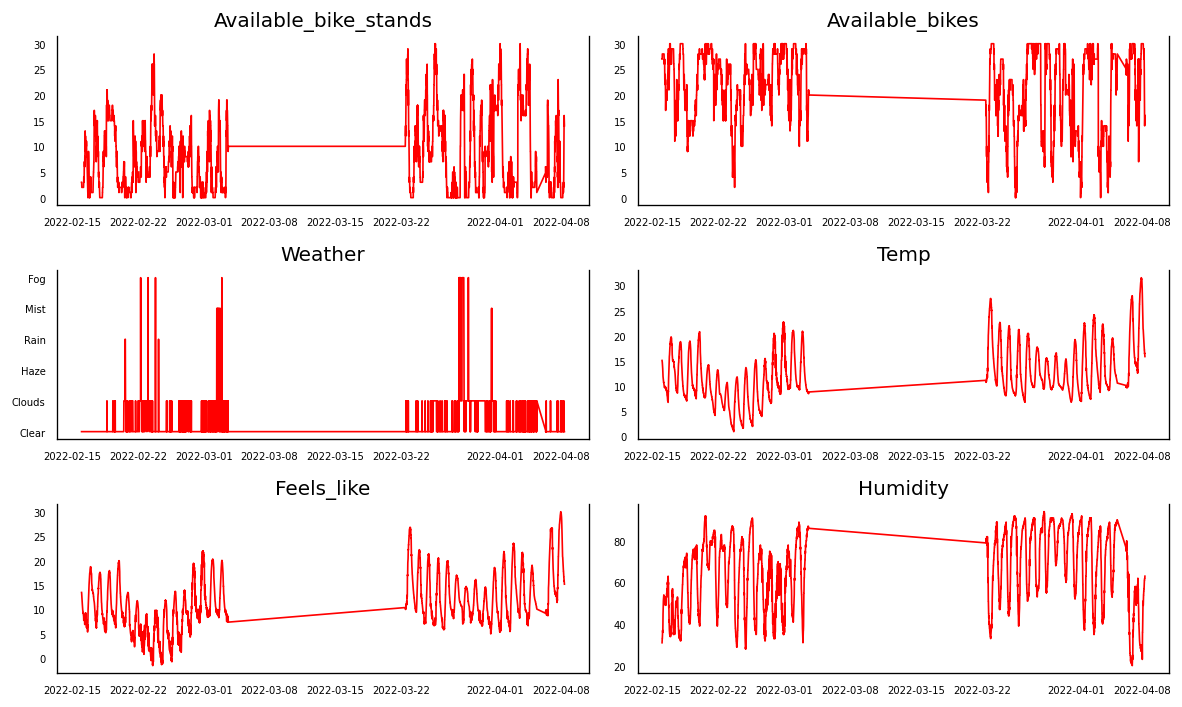

In [17]:
# Code reference https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Plot the current data 

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_test_station[df_test_station.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_test_station.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

Since our database is getting charged at the end of Febuary, we stop the database during the spring break 

In [18]:
# Code reference https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Perform the chi-square test on the time series

from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'

df_test_station = df_test_station.drop(["Weather"], axis=1)

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
    
grangers_causation_matrix(df_test_station, variables = df_test_station.columns) 

/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  wa

,Available_bike_stands_x,Available_bikes_x,Temp_x,Feels_like_x,Humidity_x
Available_bike_stands_y,1.0,0.0,0.0,0.0000,0.0
Available_bikes_y,0.0,1.0,0.0,0.0000,0.0
Temp_y,0.0,0.0,1.0,0.0012,0.0
Feels_like_y,0.0,0.0,0.0,1.0000,0.0
Humidity_y,0.0,0.0,0.0,0.0000,1.0


From the table above, we can reject the null hypothesis and assume that there are casual relationship between each features.

In [19]:
# Code reference https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Perform the cointergartion test 

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_test_station)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Available_bike_stands ::  269.08    > 60.0627   =>   True
Available_bikes ::  143.08    > 40.1749   =>   True
Temp   ::  73.29     > 24.2761   =>   True
Feels_like ::  9.17      > 12.3212   =>   False
Humidity ::  0.0       > 4.1296    =>   False


In [20]:
# Drop the feature that are not satisfied with the assumption of the model
# For humidity, I think it's a good numeric estimator for wether.

df_test_station = df_test_station.drop(['Feels_like'], axis=1)
nobs = 4

# Split train and test set
df_train, df_test = df_test_station[0:-nobs], df_test_station[-nobs:]

# Check size
print(df_train.shape)  # (4190, 4)
print(df_test.shape)  # (4, 4)

(4495, 4)
(4, 4)


In [21]:
# Code reference https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Perform the AD test to check stationarity

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 6), 'pvalue':round(r[1], 6), 'n_lags':round(r[2], 6), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [22]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "Available_bike_stands" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.338968
 No. Lags Chosen       = 22
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Available_bikes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.395335
 No. Lags Chosen       = 22
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Temp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

We can tell that all features are stationary

In [23]:
# Code reference https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Select the lag order by exhaustively iterative through different value and compare it's AIC.

model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -4.910210601197957
BIC :  -4.881681458106078
FPE :  0.007370935867048398
HQIC:  -4.900157368075726 

Lag Order = 2
AIC :  -5.01737591381964
BIC :  -4.966013809941045
FPE :  0.006621880457229957
HQIC:  -4.999276490670074 

Lag Order = 3
AIC :  -5.075567198151768
BIC :  -5.001363553355545
FPE :  0.0062475422441164614
HQIC:  -5.0494183796725745 

Lag Order = 4
AIC :  -5.092682664966503
BIC :  -4.995628893919973
FPE :  0.00614152301015041
HQIC:  -5.0584812438552085 

Lag Order = 5
AIC :  -5.1465649204788475
BIC :  -5.026652432643247
FPE :  0.005819361985991257
HQIC:  -5.104307687431108 

Lag Order = 6
AIC :  -5.196264607998173
BIC :  -5.0534848076243275
FPE :  0.005537212036657019
HQIC:  -5.145948351706076 

Lag Order = 7
AIC :  -5.304498240322412
BIC :  -5.138842526446411
FPE :  0.004969194517863656
HQIC:  -5.246119747472782 

Lag Order = 8
AIC :  -5.3865349197089625
BIC :  -5.1979946861478235
FPE :  0.004577813214995893
HQIC:  -5.320090974981662 

Lag Order = 9
AIC :

/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


In [24]:
# Choose 4 as the lag order

model = VAR(df_train)
result = model.fit(4)

# Show the result summary of the model
result.summary()

/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Apr, 2022
Time:                     09:33:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -4.99563
Nobs:                     4491.00    HQIC:                  -5.05848
Log likelihood:          -13986.2    FPE:                 0.00614152
AIC:                     -5.09268    Det(Omega_mle):      0.00604941
--------------------------------------------------------------------
Results for equation Available_bike_stands
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            8.307870         1.865415            4.454           0.000
L1.Available_bike_stands         0.871921         0.175548            4.967           0.000


In [25]:
# Code reference https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# Perform the DW test to check serial correlation

from statsmodels.stats.stattools import durbin_watson

def adjust(val, length= 6): return str(val).ljust(length)

out = durbin_watson(result.resid)

for col, val in zip(df_test_station.columns, out):
    print(adjust(col), ':', round(val, 2))
    

Available_bike_stands : 2.0
Available_bikes : 2.0
Temp   : 2.07
Humidity : 2.03


In [26]:
# Predict the result

lagged_Values = df_train.values[-4:]
pred = result.forecast(y=lagged_Values, steps=4) 

df_forecast=pd.DataFrame(data=pred, index=df_test_station.index[-nobs:], columns=df_test_station.columns + '_predict')
df_forecast

,Available_bike_stands_predict,Available_bikes_predict,Temp_predict,Humidity_predict
Time,,,,
2022-04-08 08:10:02,15.824486,14.167168,16.464940,62.310439
2022-04-08 08:11:50,15.644916,14.340734,16.442952,62.336007
2022-04-08 08:21:12,15.414216,14.569179,16.473717,62.326844
2022-04-08 08:32:01,15.183881,14.798540,16.498234,62.236587


In [27]:
df_test

,Available_bike_stands,Available_bikes,Temp,Humidity
Time,,,,
2022-04-08 08:10:02,15,15,16.11,62
2022-04-08 08:11:50,15,15,16.12,62
2022-04-08 08:21:12,15,15,16.12,62
2022-04-08 08:32:01,14,16,15.85,63


<AxesSubplot:xlabel='Time'>

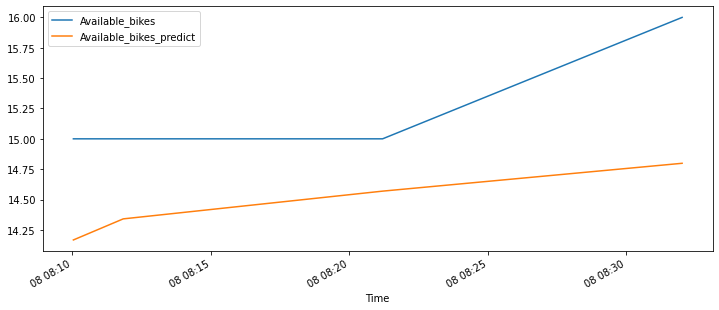

In [28]:
# Available bike predict
df_test["Available_bikes"].plot(figsize=(12,5),legend=True)
df_forecast['Available_bikes_predict'].plot(legend=True)

<AxesSubplot:xlabel='Time'>

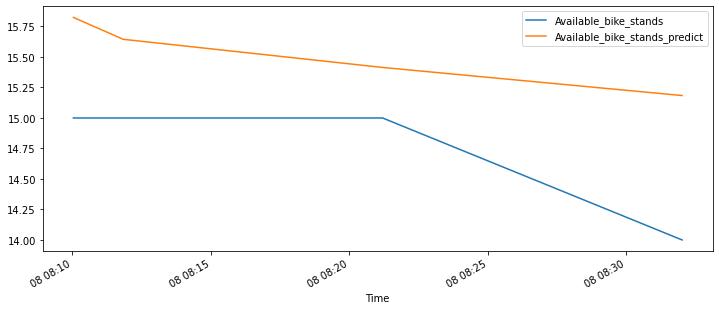

In [29]:
# Available bike stands
df_test["Available_bike_stands"].plot(figsize=(12,5),legend=True)
df_forecast['Available_bike_stands_predict'].plot(legend=True)

<AxesSubplot:xlabel='Time'>

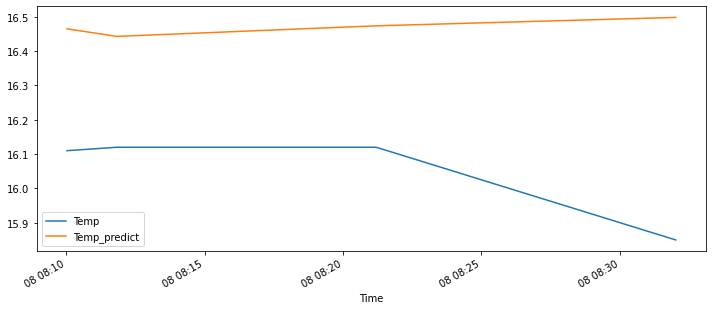

In [30]:
# Temp
df_test["Temp"].plot(figsize=(12,5),legend=True)
df_forecast['Temp_predict'].plot(legend=True)

<AxesSubplot:xlabel='Time'>

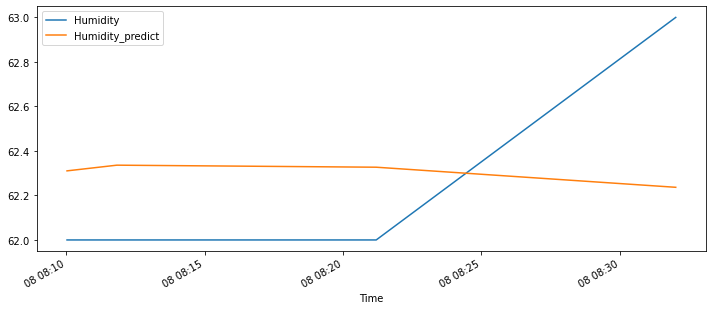

In [31]:
# Humidity
df_test["Humidity"].plot(figsize=(12,5),legend=True)
df_forecast['Humidity_predict'].plot(legend=True)

In [32]:
# Evaluation - RMSE
#  
def rmse (forecast, actual):
    return np.mean(((forecast - actual)**2)**0.5)

# Rmse Available bikes
print("RMSE for available bikes: ", rmse(df_forecast['Available_bikes_predict'], df_test["Available_bikes"]))
# RMSE for available bike stands
print("RMSE for available bikes stands: ", rmse(df_forecast['Available_bike_stands_predict'], df_test["Available_bike_stands"]))
# RMSE for Temp
print("RMSE for Temp: ", rmse(df_forecast['Temp_predict'], df_test["Temp"]))
# RMSE for Humidity
print("RMSE for Humidity: ", rmse(df_forecast['Humidity_predict'], df_test["Humidity"]))

RMSE for available bikes:  0.7810947326387039
RMSE for available bikes stands:  0.7668745499307561
RMSE for Temp:  0.41996060627207
RMSE for Humidity:  0.4341757934013213
